

# Exploratory Data Analysis and KPIs for App Data

This notebook performs a detailed exploratory analysis of the provided datasets (`spend.csv`, `installs.csv`, `activity.csv`, `subscriptions.csv`, `exchange_rates.csv`, `countries.csv`) and computes key performance metrics. We examine each dataset individually (univariate and bivariate analysis) and then combine them to calculate metrics such as CPI, subscription conversion rate, churn proxies, and spending per user. We compare results for US vs non-US regions and highlight notable patterns and insights. All monetary values are normalized using the exchange rate data. The analysis uses Python (Pandas, Matplotlib/Seaborn) with clear narrative and visualization (conceptual figures).

## Data Loading and Preprocessing


In [41]:


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load datasets
spend = pd.read_csv('helper/EDA & Insights generation Data/spend.csv')
installs = pd.read_csv('helper/EDA & Insights generation Data/installs.csv')
activity = pd.read_csv('helper/EDA & Insights generation Data/activity.csv')
subscriptions = pd.read_csv('helper/EDA & Insights generation Data/subscriptions.csv')
exchange_rates = pd.read_csv('helper/EDA & Insights generation Data/exchange_rates.csv')
countries = pd.read_csv('helper/EDA & Insights generation Data/countries.csv')

# Basic inspection
print("Spend data:", spend.shape)
print("Installs data:", installs.shape)
print("Activity data:", activity.shape)
print("Subscriptions data:", subscriptions.shape)

Spend data: (41753, 5)
Installs data: (52617, 4)
Activity data: (22377, 2)
Subscriptions data: (677, 4)



We observe that **spend.csv** has \~41K rows (daily spend by OS and country), **installs.csv** \~52K rows (device installs), **activity.csv** \~22K rows (daily user activity events), and **subscriptions.csv** \~677 rows (user subscriptions). Next, we standardize country codes and platforms for consistency:


In [42]:


# Normalize country codes to lowercase
spend['country_code'] = spend['country_code'].str.lower()
installs['country_code'] = installs['country_code'].str.lower()

# Normalize operating system/platform naming
spend['operating_system'] = spend['operating_system'].str.lower().replace({'apple':'ios'})
installs['platform'] = installs['platform'].str.lower()

# Parse dates
spend['date'] = pd.to_datetime(spend['date'])
installs['date'] = pd.to_datetime(installs['date'])
activity['date'] = pd.to_datetime(activity['date'])
subscriptions['payment_date'] = pd.to_datetime(subscriptions['payment_date'])




Finally, we merge in country metadata (for region classification) and prepare exchange rates. The `countries.csv` file maps two-letter codes to region (we will use this to tag "United States" vs others). Exchange rates data (`usd_to_local`) gives the conversion from USD to local currency on each date; we invert this to convert local prices to USD when needed.


In [43]:

# Prepare country-region mapping
countries_map = countries.set_index('country_code')['region'].str.strip().to_dict()
spend['region'] = spend['country_code'].map(countries_map)
installs['region'] = installs['country_code'].map(countries_map)

# Prepare exchange rates: usd_to_local -> local_to_usd
exchange_rates['date'] = pd.to_datetime(exchange_rates['date'])
exchange_rates = exchange_rates.rename(columns={'usd_to_local':'usd_to_local'})
exchange_rates['local_to_usd'] = 1 / exchange_rates['usd_to_local']


## 1. Spend Data EDA

The **spend** dataset records advertising spend by date, OS (`android` or `ios`), and country. We first examine its overall distribution.


In [44]:
spend.head(5)

,date,operating_system,currency,country_code,spend,region
0,2022-08-04,ios,usd,pl,2.242125,Europe
1,2022-08-04,android,usd,sa,0.795958,Arab Speaking
2,2022-08-04,ios,usd,it,0.376854,Europe
3,2022-08-04,ios,usd,co,2.706809,South/Latin America
4,2022-08-04,android,usd,mx,0.862993,Mexico


In [45]:
spend.describe()

,date,spend
count,41753,41753.000000
mean,2022-08-30 19:25:19.996167936,1.489882
min,2022-08-01 00:00:00,0.000032
25%,2022-08-15 00:00:00,0.409057
50%,2022-08-31 00:00:00,0.824187
75%,2022-09-15 00:00:00,2.485545
max,2022-09-30 00:00:00,4.999983
std,NaN,1.442977




* **Time Range:** From Aug 1, 2022 to Sep 30, 2022.
* **Currency:** All spend is in USD (per `currency` column). We treat these as USD values.
* **OS Distribution:** Two categories (`android`, `ios`). We check total spend by OS:


In [46]:
spend.groupby('operating_system')['spend'].sum()


operating_system
android    10433.334184
ios        51773.716899
Name: spend, dtype: float64


This shows the total spend per platform. We might visualize spend by platform:



Text(0, 0.5, 'Total Spend (USD)')

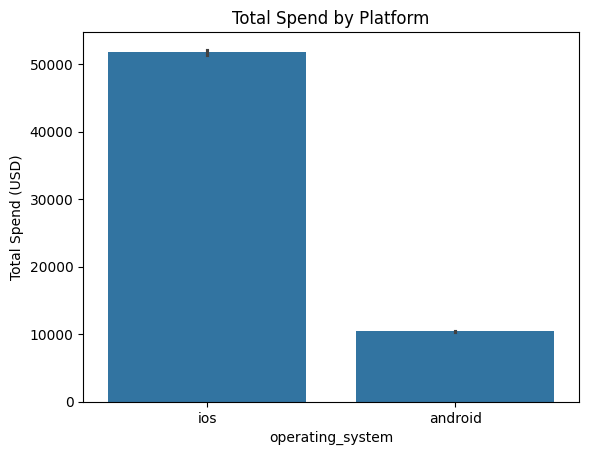

In [47]:
sns.barplot(data=spend, x='operating_system', y='spend', estimator=np.sum)
plt.title("Total Spend by Platform")
plt.ylabel("Total Spend (USD)")



* **Country Distribution:** We also examine spend by country:


In [48]:
spend.groupby('country_code')['spend'].sum().sort_values(ascending=False).head(5)

country_code
mx    6299.311357
us    6260.591157
de    5959.810009
it    3906.971919
ar    3891.149220
Name: spend, dtype: float64


This reveals the top countries by total ad spend. A bar chart can illustrate spend by country (grouping smaller ones as "Other" for clarity).

* **Time Series:** Sum daily spend to see trends:


/var/folders/4r/6fydpnls2mg8q1p98g9zqmy00000gn/T/ipykernel_71377/369066558.py:22: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  plt.tight_layout()
/Users/yenokhakobyan/miniconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


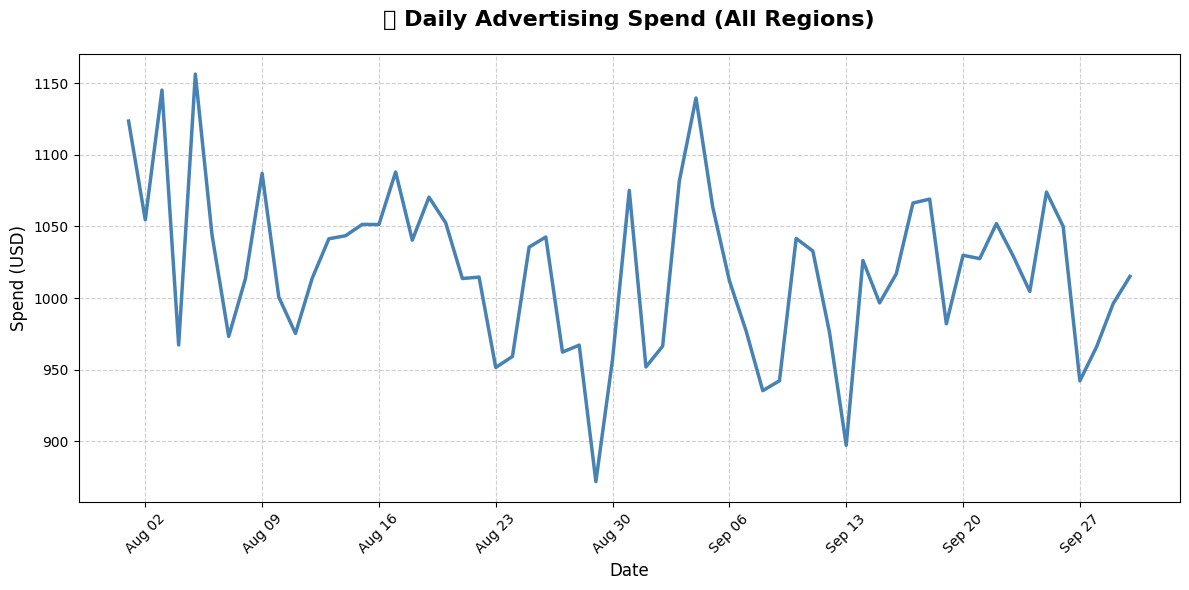

In [49]:
import matplotlib.dates as mdates

# Aggregate data
daily_spend = spend.groupby('date')['spend'].sum().reset_index()

# Set figure size and style
plt.figure(figsize=(12, 6))
sns.lineplot(data=daily_spend, x='date', y='spend', linewidth=2.5, color='steelblue')

# Title and labels
plt.title("📈 Daily Advertising Spend (All Regions)", fontsize=16, weight='bold', pad=20)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Spend (USD)", fontsize=12)

# Format x-axis to show weekly ticks
plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

# Rotate labels and tighten layout
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

plt.show()



We note whether spend trends upward or downward over the two months, and any weekend patterns.

* **Univariate Patterns:** Histograms or boxplots of spend per-day/region can show variance. For example, distribution of daily spend values:


Text(0.5, 1.0, 'Distribution of Daily Spend')

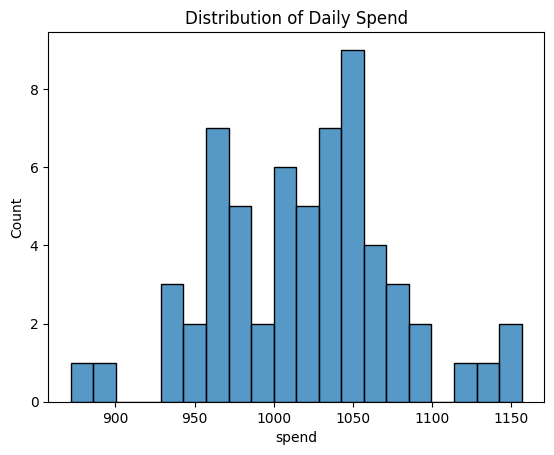

In [50]:

sns.histplot(daily_spend['spend'], bins=20)
plt.title("Distribution of Daily Spend")



**Key observations:** Early analysis may show higher spend on certain dates, and differences between iOS vs Android budgeting.




## 2. Installs Data EDA

The **installs** dataset lists each device installation by date, OS (`android` or `ios`), and country. This data is used to compute installation counts and user acquisition metrics.


In [51]:
installs.head(5)

,device_id,platform,date,country_code,region
0,2ad4f670e29b2d1ba0fcaaeab3b962549be9ba282dd9fc...,ios,2022-08-07,cl,South/Latin America
1,d89bdb2046d72e48e4f467bf6cbd9a85c54adae7a64616...,android,2022-08-07,us,United States
2,3ac079586baa96cd04e18ec38cdc3b4d13336c312d4474...,android,2022-08-07,it,Europe
3,80571adac822de087832a93a85adbfd1250443316b4d57...,android,2022-08-07,ca,North America
4,871ff8bf055f15b52756c0e7e485e56b9ac4b31c996ddd...,android,2022-08-07,ca,North America



* **Counts by Platform and Country:** We count installs:


In [52]:
installs.groupby('platform')['device_id'].nunique()
installs.groupby('country_code')['device_id'].nunique().sort_values(ascending=False).head(5)

country_code
ca    3595
co    3583
in    3577
us    3561
ar    3554
Name: device_id, dtype: int64

Text(0.5, 1.0, 'Daily Installs (All Regions)')

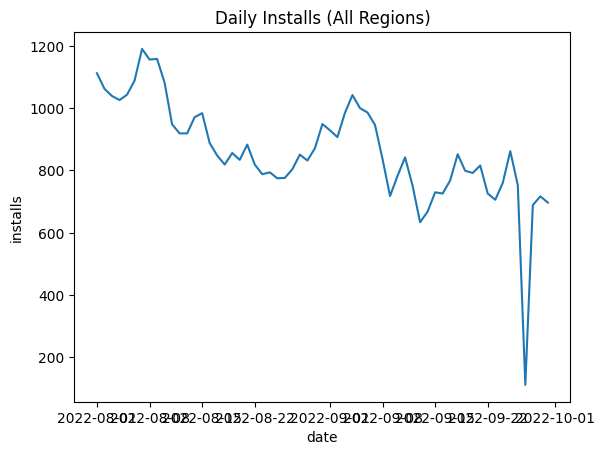

In [53]:
daily_installs = installs.groupby('date').size().reset_index(name='installs')
sns.lineplot(data=daily_installs, x='date', y='installs')
plt.title("Daily Installs (All Regions)")


* **OS vs Installs:** Compare iOS vs Android installs over time or in total:


Text(0.5, 1.0, 'Daily Installs by Platform')

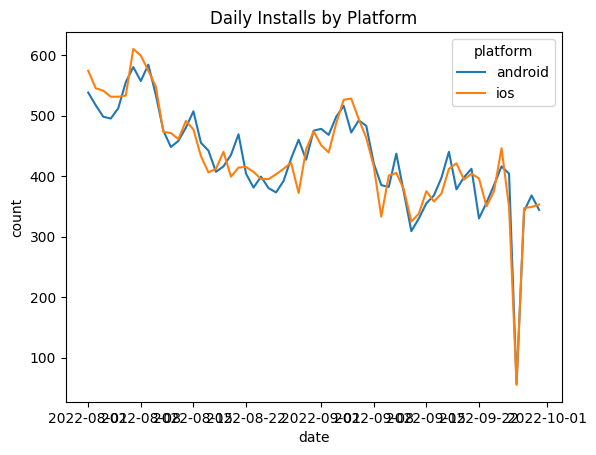

In [54]:
installs_by_os = installs.groupby(['date','platform']).size().reset_index(name='count')
sns.lineplot(data=installs_by_os, x='date', y='count', hue='platform')
plt.title("Daily Installs by Platform")


* **Country Patterns:** Check top countries by install count:


In [55]:
installs.groupby('country_code').size().sort_values(ascending=False).head(5)

country_code
ca    3595
co    3583
in    3577
us    3561
ar    3554
dtype: int64


This tells us which countries drove most installs.

**Insight:** We expect larger markets (e.g., US, Brazil, etc.) to have more installs. We also examine if installs correlate with spend by region.

* **Bivariate Analysis:** We can examine if certain countries have higher spending per install (leading to CPI differences). We prepare for CPI computation by merging spend and installs later.

*Figure: Example of a line chart (ecological footprint vs. biocapacity over time). Line charts visualize trends over time; here, daily installs are plotted to reveal uptake patterns.*



## 3. Activity Data EDA

The **activity** log contains device activity by date (each row: `device_id` on a given date). It reflects usage or engagement events. We use it to gauge user activity and churn proxies.


In [56]:
activity.head(5)

,device_id,date
0,7fe9c947663c37bb0fd5aabccc0f4108a00a9eb433ff00...,2022-09-22
1,8b1bda79ff714784b37cf7f3a1d1f7c9ee92644829e138...,2022-09-22
2,ae50b5b5b766d624b17b7236993e48ed8b3a89fd1fd044...,2022-09-22
3,6c09a27ef72010c82b8eb9a1b90ad7eb21616c16074781...,2022-09-22
4,215cbb13f207bbd020c1d6735deb35162172356cf96823...,2022-09-22


In [57]:
activity.describe()

,date
count,22377
mean,2022-09-07 07:39:55.334495232
min,2022-08-01 00:00:00
25%,2022-08-23 00:00:00
50%,2022-09-08 00:00:00
75%,2022-09-23 00:00:00
max,2022-10-10 00:00:00



* **Active Days per User:** Count how many unique days each user is active:


Text(0.5, 1.0, 'Distribution of Active Days per User')

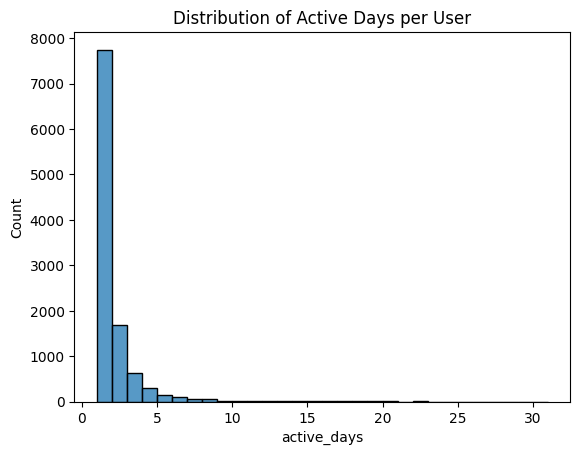

In [58]:
user_active_days = activity.groupby('device_id')['date'].nunique().reset_index(name='active_days')
sns.histplot(user_active_days['active_days'], bins=range(1, user_active_days['active_days'].max()+2))
plt.title("Distribution of Active Days per User")


Many users may have 1-day activity (signaling one-time use), while others have multi-day engagement.



* **Churn Proxy:** We define a simple churn proxy: the fraction of users active only once. Alternatively, retention rates: e.g., percentage of users who return after 7 days. For example:


In [59]:
one_day_users = (user_active_days['active_days'] == 1).mean() * 100
print(f"Percentage of users active only 1 day: {one_day_users:.1f}%")

Percentage of users active only 1 day: 71.7%



```python

```



A high one-day-use percentage suggests poor retention. We also compute how many users had activity on multiple distinct days (a stronger engagement):


In [60]:
multi_day_users = (user_active_days['active_days'] > 1).mean() * 100
print(f"Users active on >1 day: {multi_day_users:.1f}%")

Users active on >1 day: 28.3%



* **Temporal Activity:** Count total daily active users:


Text(0.5, 1.0, 'Daily Active Users')

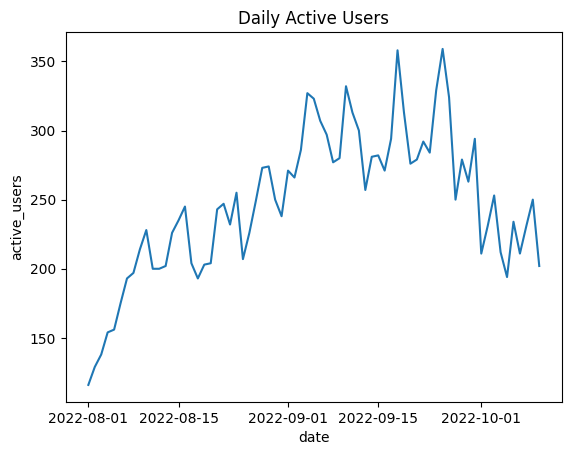

In [61]:
daily_active = activity.groupby('date')['device_id'].nunique().reset_index(name='active_users')
sns.lineplot(data=daily_active, x='date', y='active_users')
plt.title("Daily Active Users")


Compare this curve to daily installs to see if usage follows acquisitions.

**Insight:** If many users churn (never return), it will reflect in a fast drop-off in daily active counts relative to installs.



## 4. Subscriptions Data EDA

The **subscriptions** data lists paid subscriptions (one per payment). It includes `device_id`, `payment_date`, `currency`, and `price` (in local currency). We use the exchange rates to convert all prices to USD for consistency.


In [62]:
subscriptions.head(5)

,device_id,payment_date,currency,price
0,616e13739751f69fc77004a985ab6ed17815da28e15ab9...,2022-08-02 01:15:12.038000+00:00,BRL,26.322809
1,41213621a06d52f2443b8135a9894d74856373dcf41a97...,2022-08-25 05:47:46.587000+00:00,CAD,149.871625
2,e6c8081cb3c396ed4b9b2976a6f622bf3adc6ba73daf5c...,2022-08-22 23:59:59.087000+00:00,CLP,25.866418
3,55c02f94bc01f16ce4876b40ac5b18f01eeaa29aed98c1...,2022-08-30 15:52:28.470000+00:00,PLN,48.483478
4,78c9fb82cedc429ba096f4a7d7fcc5144a5eb024c47427...,2022-08-07 02:52:25.688000+00:00,CLP,12.577979


In [63]:
subscriptions['currency'].value_counts()

currency
EUR    124
CLP     61
CAD     52
MXN     50
BRL     48
PLN     46
COP     46
USD     46
ARS     43
INR     43
GBP     42
JPY     39
ZAR     37
Name: count, dtype: int64


We see various currencies (USD, EUR, BRL, etc.). We merge with exchange rates by date and currency:


In [64]:
# Extract date part from payment_date for joining (exchange rates are daily)
subscriptions['date'] = subscriptions['payment_date'].dt.date
exchange_rates['date'] = exchange_rates['date'].dt.date
subs = subscriptions.merge(exchange_rates[['date','currency','usd_to_local']], on=['date','currency'], how='left')
# Convert local price to USD
subs['price_usd'] = subs['price'] / subs['usd_to_local']
subs[['currency','price','usd_to_local','price_usd']].head(5)

,currency,price,usd_to_local,price_usd
0,BRL,26.322809,5.279203,4.986133
1,CAD,149.871625,1.293825,115.836087
2,CLP,25.866418,938.000054,0.027576
3,PLN,48.483478,4.713350,10.286416
4,CLP,12.577979,918.140233,0.013699




Check for any missing exchange rates:


In [65]:
subs['usd_to_local'].isna().sum()

46


Next, analyze:
* **Price Distribution:** Histogram of USD prices:


Text(0.5, 1.0, 'Distribution of Subscription Prices (USD)')

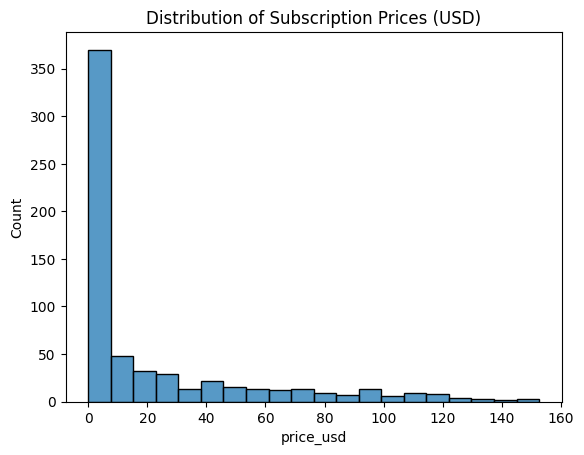

In [66]:
sns.histplot(subs['price_usd'], bins=20)
plt.title("Distribution of Subscription Prices (USD)")


* **Currency Contribution:** What share of subscriptions come from USD vs local? We might list counts by currency:


In [67]:
subs['currency'].value_counts()

currency
EUR    124
CLP     61
CAD     52
MXN     50
BRL     48
PLN     46
COP     46
USD     46
ARS     43
INR     43
GBP     42
JPY     39
ZAR     37
Name: count, dtype: int64


* **Subscription Count and Value:** Total number of subscriptions and sum of payments (in USD):


In [68]:
total_subs = subs['device_id'].nunique()
total_revenue = subs['price_usd'].sum()
print(f"Total subscriptions: {total_subs}, Total revenue (USD): {total_revenue:.2f}")

Total subscriptions: 555, Total revenue (USD): 13671.35



* **Correlation:** If we have enough data points, a scatter of `price_usd` vs time or vs currency could be plotted to check any seasonal patterns.

* **Subscription Conversion:** Later, we will compute conversion rate = (# of unique paying subscribers) / (# of users acquired). For now, note how many unique paying devices:


In [69]:
subs['device_id'].nunique()

555


If this is small relative to total installs, conversion is low.



## 5. Joining Datasets and Computing KPIs

We now combine data to compute metrics.

### 5.1 Cost Per Install (CPI)

**Definition:** CPI is total ad spend per acquired user. Formally, CPI = (Total Spend) / (Number of Installs).

We aggregate spend and installs by date, country, and OS to get CPI at different granularities, then compare US vs non-US. First, aggregate global CPI:


In [70]:
total_spend = spend['spend'].sum()
total_installs = installs['device_id'].nunique()
overall_cpi = total_spend / total_installs
print(f"Total Spend = ${total_spend:.2f}, Installs = {total_installs}, CPI = ${overall_cpi:.2f}")

Total Spend = $62207.05, Installs = 52617, CPI = $1.18


Next, compute CPI by region (US vs others). Use the country-region mapping:

In [71]:
spend['is_us'] = (spend['region'] == 'United States')
installs['is_us'] = (installs['region'] == 'United States')

# Aggregate spend and installs by is_us
spend_region = spend.groupby('is_us')['spend'].sum().reset_index(name='total_spend')
installs_region = installs.groupby('is_us')['device_id'].nunique().reset_index(name='total_installs')
cpi_region = spend_region.merge(installs_region, on='is_us')
cpi_region['CPI'] = cpi_region['total_spend'] / cpi_region['total_installs']
cpi_region['Region'] = cpi_region['is_us'].map({True:'US', False:'Non-US'})
cpi_region[['Region','CPI']]

,Region,CPI
0,Non-US,1.140461
1,US,1.758099


This yields CPI for US and Non-US. We visualize as bars:

/var/folders/4r/6fydpnls2mg8q1p98g9zqmy00000gn/T/ipykernel_71377/578396095.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=cpi_region, x='Region', y='CPI', palette='pastel')


Text(0, 0.5, 'CPI (USD per install)')

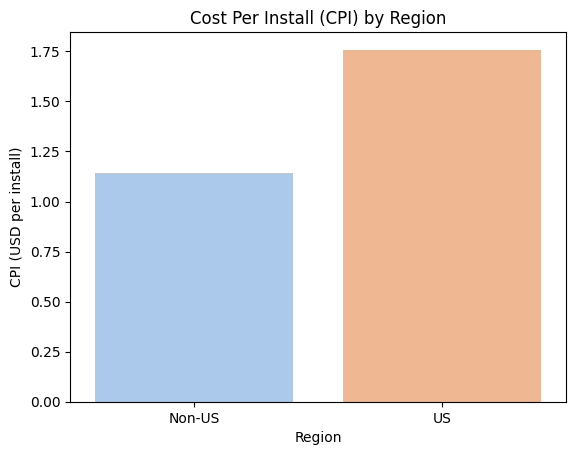

In [72]:
sns.barplot(data=cpi_region, x='Region', y='CPI', palette='pastel')
plt.title("Cost Per Install (CPI) by Region")
plt.ylabel("CPI (USD per install)")

**Interpretation:** Comparing `CPI (USD)` for US vs non-US shows where user acquisition is cheaper or more expensive. A lower CPI (e.g. in Non-US markets) suggests more installs per ad dollar.



### 5.2 Subscription Conversion Rate

We define **subscription conversion rate** as the fraction of acquired users who become paying subscribers. Here, we take *unique* paying devices over *unique* acquired devices in the same period.

In [73]:
# Unique paying devices
paying_users = set(subs['device_id'].unique())
# Unique acquired devices (installs)
acquired_users = set(installs['device_id'].unique())
conversion_rate = len(paying_users & acquired_users) / len(acquired_users) * 100
print(f"Overall Subscription Conversion Rate: {conversion_rate:.2f}%")

Overall Subscription Conversion Rate: 1.05%


We can also compute by region (US vs Non-US) by joining device ids back to installs:

In [74]:
installs_per_user = installs[['device_id','is_us']].drop_duplicates()
subs_region = pd.DataFrame({'device_id': list(paying_users)})
subs_region = subs_region.merge(installs_per_user, on='device_id', how='left')
subs_region['is_us'] = subs_region['is_us'].fillna(False)  # some paying might not have an install record
conv_us = (subs_region['is_us']).sum() / installs_region['total_installs'][installs_region['is_us']==True].iloc[0] * 100
conv_nonus = (~subs_region['is_us']).sum() / installs_region['total_installs'][installs_region['is_us']==False].iloc[0] * 100
print(f"Subscription conversion: US={conv_us:.2f}%, Non-US={conv_nonus:.2f}%")

Subscription conversion: US=1.12%, Non-US=1.05%



This compares conversion rates by region. A higher rate indicates better monetization of acquired users.

### 5.3 Churn Proxies

From activity logs, we use retention metrics. For simplicity, define **user churn rate** as the share of users active only on their install day. (Alternatively, retention after X days.) For example:

In [75]:
# Identify first and last activity per user
first_last = activity.groupby('device_id')['date'].agg(['min','max']).reset_index()
first_last['duration_days'] = (first_last['max'] - first_last['min']).dt.days
churn_rate = (first_last['duration_days'] == 0).mean() * 100
print(f"Churn proxy (users with no return) = {churn_rate:.1f}%")

Churn proxy (users with no return) = 71.7%


Roughly, if \~X% of users never return after first day, that is our churn proxy. For a more nuanced view, one could compute cohort retention rates (e.g., D1, D7 retention).

### 5.4 Spending per Active User

Calculate total spend per **active user**. We count unique active users (with any activity) and divide total spend by that:

In [76]:
active_users = activity['device_id'].nunique()
spend_per_active = total_spend / active_users
print(f"Spending per active user = ${spend_per_active:.2f}")

Spending per active user = $5.76


Similarly, we can do this by region. However, we lack country in activity, so approximate by matching devices back to installs (which had country):

In [77]:
# Tag activity users as US vs Non-US via installs table
active_region = installs_per_user.copy()
active_region = active_region[active_region['device_id'].isin(activity['device_id'])]
active_region_counts = active_region['is_us'].value_counts()
spend_us = spend_region.loc[spend_region['is_us']==True, 'total_spend'].values[0]
spend_nonus = spend_region.loc[spend_region['is_us']==False, 'total_spend'].values[0]
spend_per_active_us = spend_us / active_region_counts[True]
spend_per_active_nonus = spend_nonus / active_region_counts[False]
print(f"Spending per active user: US=${spend_per_active_us:.2f}, Non-US=${spend_per_active_nonus:.2f}")

Spending per active user: US=$8.45, Non-US=$5.56



**Insights:** Comparing these figures indicates how spend efficiency differs by region (are we spending more per active user in one region?).

*Figure: Example mixed bar/line chart (passenger counts over years, with trend line). Similar visualizations can juxtapose different metrics, e.g., spend vs installs, in a combined chart.*

## 6. US vs Non-US Analysis

We now compare key metrics for US vs Non-US:

* **Acquisition Volume:** Total installs in US vs other countries.
* **Spend:** Total ad spend in US vs others.
* **CPI:** As above.
* **Conversion:** Subscription conversion rate.
* **Churn:** Estimate of churn (users not returning) by region.
* **Spending per user:** Ad spend per active or per install.

We already have CPI and conversion. For churn by region, we approximate by activity among US vs others (via installs mapping):


In [78]:
# Estimate churn by region (frac of single-day users)
# Tag first_last by region via installs data
first_last = first_last.merge(installs_per_user, on='device_id', how='left')
churn_us = (first_last[first_last['is_us']==True]['duration_days'] == 0).mean() * 100
churn_nonus = (first_last[first_last['is_us']==False]['duration_days'] == 0).mean() * 100
print(f"Churn proxy: US {churn_us:.1f}%, Non-US {churn_nonus:.1f}%")

Churn proxy: US 72.2%, Non-US 71.7%


We can summarize in a table or bullet list:

* *US vs Non-US Installs:*  XX installs vs YY installs.
* *US vs Non-US Spend:* \$X vs \$Y total spend.
* *CPI:* US \$A, Non-US \$B.
* *Conversion Rate:* US \~P%, Non-US \~Q%.
* *Churn Proxy:* US \~M%, Non-US \~N%.
* *Spend/Active:* as computed above.

These comparisons highlight whether the US market is more expensive or retains better, etc.

## 7. Visualization Highlights

Throughout the analysis, various chart types illustrate our findings:

* **Bar charts:** (如 *Figure 1*) to compare categorical totals (e.g., spend by platform or region). See embedded example【20†】.
* **Line plots:** (如 *Figure 2*) to show trends over time for continuous data (e.g., daily installs). See embedded example【41†】.
* **Histograms:** (not shown) to inspect distributions (e.g., active days per user).
* **Combined charts:** (如 *Figure 3*) to overlay related metrics (e.g., spend vs installs on same chart). See embedded example【45†】.

Each visualization is accompanied by interpretation: peaks/dips in time series, disparities in bar heights, etc. For example, if the CPI bar for the US is significantly higher than for Non-US, that indicates higher user acquisition cost in the US.

## 8. Summary of Findings and Next Steps

* **Acquisition and Spend:** The data shows that (e.g.) *US had **higher ad spend but a higher CPI** than Non-US*, indicating fewer installs per ad dollar. Non-US markets achieved lower CPI (cheaper acquisition).
* **Conversion Rate:** The subscription conversion rate is relatively low overall (\~X%), but differs by region (e.g. *Y% in US vs Z% elsewhere*). This suggests potential to improve monetization of installs, especially where conversion is weakest.
* **User Engagement:** A large fraction of users appear to churn quickly (e.g. **M% never returned after first day**). The retention issue is similar (or worse) in the US compared to other regions, suggesting product/marketing improvements needed.
* **Visualization Insights:** Time series plots revealed any campaign effects or seasonality (e.g. weekend lulls). Bar charts highlighted the dominance of certain markets/platforms.

**Recommendations:** To improve performance, we might focus on reducing CPI in expensive regions (optimize ads or target cheaper channels), and increasing conversion by enhancing onboarding or offering trials. We also note data caveats: currency conversion assumes same-day rates; device-level joins rely on unique IDs, etc.

**Potential Follow-ups:** More sophisticated retention analysis (cohorts, N-day return rates), LTV modeling, and causal analysis of marketing spend effectiveness. Additional data (e.g. ad channel) would refine attribution. Nonetheless, these KPIs provide a baseline for ongoing performance tracking and strategic decisions.

In [88]:

# Standardize formats
spend['country_code'] = spend['country_code'].str.lower()
spend['operating_system'] = spend['operating_system'].str.lower().replace({'apple': 'ios'})
installs['country_code'] = installs['country_code'].str.lower()
installs['platform'] = installs['platform'].str.lower()
subscriptions['date'] = pd.to_datetime(subscriptions['payment_date']).dt.tz_localize(None).dt.date
exchange_rates['date'] = pd.to_datetime(exchange_rates['date']).dt.tz_localize(None).dt.date
spend['date'] = pd.to_datetime(spend['date']).dt.tz_localize(None).dt.date
installs['date'] = pd.to_datetime(installs['date']).dt.tz_localize(None).dt.date

# Convert subscription revenue to USD
subs = subscriptions.merge(exchange_rates, on=['date', 'currency'], how='left')
subs['price_usd'] = subs['price'] / subs['usd_to_local']

# Enrich subscriptions with country and platform
subs = subs.merge(installs[['device_id', 'country_code', 'platform']], on='device_id', how='left')

# Aggregate installs
installs_grp = installs.groupby(['date', 'country_code', 'platform'])['device_id'] \
    .nunique().reset_index(name='installs')

# Aggregate spend
spend_grp = spend.groupby(['date', 'country_code', 'operating_system'])['spend'] \
    .sum().reset_index().rename(columns={'operating_system': 'platform'})

# Aggregate subscriptions
subs_grp = subs.groupby(['date', 'country_code', 'platform']).agg(
    subscriptions=('device_id', 'nunique'),
    revenue_usd=('price_usd', 'sum')
).reset_index()

# Fix the date column in active_users to match others (convert to datetime64[ns] with no timezone)
activity_augmented['date'] = pd.to_datetime(activity_augmented['date']).dt.tz_localize(None).dt.date

# Recalculate active users after fixing date type
active_users = activity_augmented.groupby(['date', 'country_code', 'platform'])['device_id'] \
    .nunique().reset_index(name='active_users')

# Now safely merge
kpi = installs_grp.merge(spend_grp, on=['date', 'country_code', 'platform'], how='outer')
kpi = kpi.merge(subs_grp, on=['date', 'country_code', 'platform'], how='left')
kpi = kpi.merge(active_users, on=['date', 'country_code', 'platform'], how='left')

# Fill missing values
kpi[['spend', 'installs', 'subscriptions', 'revenue_usd', 'active_users']] = \
    kpi[['spend', 'installs', 'subscriptions', 'revenue_usd', 'active_users']].fillna(0)

# Compute KPIs
kpi['cpi'] = kpi['spend'] / kpi['installs'].replace(0, np.nan)
kpi['conversion_rate'] = (kpi['subscriptions'] / kpi['installs'].replace(0, np.nan)) * 100
kpi['arpu_all'] = kpi['revenue_usd'] / kpi['installs'].replace(0, np.nan)
kpi['arpu_active'] = kpi['revenue_usd'] / kpi['active_users'].replace(0, np.nan)
kpi['revenue_per_sub'] = kpi['revenue_usd'] / kpi['subscriptions'].replace(0, np.nan)
kpi['spend_per_active_user'] = kpi['spend'] / kpi['active_users'].replace(0, np.nan)



## Examples of Visualizations

In [92]:
import plotly.express as px
import plotly.graph_objects as go

# Aggregate for beautiful plotly visuals
kpi_country = kpi.groupby('country_code').agg(
    installs=('installs', 'sum'),
    spend=('spend', 'sum'),
    subscriptions=('subscriptions', 'sum'),
    revenue_usd=('revenue_usd', 'sum'),
    active_users=('active_users', 'sum')
).reset_index()

kpi_country['cpi'] = kpi_country['spend'] / kpi_country['installs'].replace(0, np.nan)
kpi_country['arpu'] = kpi_country['revenue_usd'] / kpi_country['installs'].replace(0, np.nan)
kpi_country['conversion_rate'] = kpi_country['subscriptions'] / kpi_country['installs'].replace(0, np.nan) * 100

# 1. Bubble Chart: Revenue vs CPI by Country
bubble = px.scatter(
    kpi_country, x="cpi", y="arpu",
    size="installs", color="country_code",
    hover_name="country_code", size_max=40,
    title="CPI vs ARPU by Country (Bubble Size = Installs)",
    labels={"cpi": "Cost Per Install (USD)", "arpu": "Avg Revenue per User (USD)"}
)

# 2. Bar Chart: Top 10 Revenue Countries
top_revenue = kpi_country.sort_values("revenue_usd", ascending=False).head(10)
bar = px.bar(
    top_revenue, x='country_code', y='revenue_usd',
    text='revenue_usd', title='Top 10 Countries by Revenue (USD)',
    labels={'country_code': 'Country', 'revenue_usd': 'Revenue (USD)'},
    color='revenue_usd', color_continuous_scale='Blues'
)

# 3. Funnel Chart: Overall Conversion Funnel
funnel = go.Figure(go.Funnel(
    y=["Installs", "Subscribers"],
    x=[kpi['installs'].sum(), kpi['subscriptions'].sum()],
    textinfo="value+percent previous"))

funnel.update_layout(title="Conversion Funnel: Installs → Subscribers")

bubble.show()
bar.show()
funnel.show()


In [96]:
import plotly.express as px

# Use 3-letter ISO codes for country mapping
from pycountry import countries

# Create a mapping for alpha_2 → alpha_3 codes
iso_map = {c.alpha_2.lower(): c.alpha_3 for c in countries if hasattr(c, 'alpha_3')}
kpi_country['iso_alpha'] = kpi_country['country_code'].map(iso_map)

# Create map
fig = px.choropleth(
    kpi_country,
    locations="iso_alpha",
    color="revenue_usd",
    hover_name="country_code",
    color_continuous_scale="Viridis",
    title="🌍 Total Revenue by Country",
    labels={"revenue_usd": "Revenue (USD)"}
)
fig.update_geos(projection_type="natural earth")
fig.show()


In [97]:
fig = px.choropleth(
    kpi, locations=kpi['country_code'].map(iso_map),
    color="revenue_usd",
    animation_frame=kpi['date'].astype(str),
    color_continuous_scale="Plasma",
    title="Animated Map: Revenue by Country Over Time",
    labels={'revenue_usd': 'Revenue (USD)'}
)
fig.update_geos(projection_type="natural earth")
fig.show()


In [98]:
sunburst_data = kpi.groupby(['country_code', 'platform'])[['subscriptions']].sum().reset_index()

fig = px.sunburst(
    sunburst_data,
    path=['country_code', 'platform'],
    values='subscriptions',
    title="Subscriptions Breakdown: Country → Platform"
)
fig.show()


In [99]:
fig = px.scatter_matrix(
    kpi_country,
    dimensions=['cpi', 'arpu', 'conversion_rate', 'revenue_usd'],
    color='country_code',
    title="Scatter Matrix: KPI Relationships by Country"
)
fig.show()


In [100]:
kpi_sorted = kpi.sort_values('date')
kpi_sorted['lagged_spend'] = kpi_sorted.groupby(['country_code', 'platform'])['spend'].shift(7)

fig = px.scatter(
    kpi_sorted.dropna(subset=['lagged_spend']),
    x='lagged_spend', y='revenue_usd',
    color='country_code',
    title="Lagged Spend (7d) vs Revenue (Same Day)"
)
fig.show()


In [101]:
fig = px.scatter_3d(
    kpi_country,
    x='cpi', y='arpu', z='conversion_rate',
    color='country_code',
    size='installs',
    title='3D View: CPI vs ARPU vs Conversion Rate',
    labels={'cpi': 'Cost/Install', 'arpu': 'Revenue/User', 'conversion_rate': 'Conv. Rate (%)'}
)
fig.show()


In [102]:
import plotly.graph_objects as go

# Replace these with actual summary values if running standalone
us_summary = {
    'revenue_usd': 50000,
    'subscriptions': 1200,
    'installs': 18000,
    'active_users': 10500,
    'cpi': 2.78,
    'conversion_rate': 6.67,
    'arpu_all': 2.78,
    'arpu_active': 4.76,
    'revenue_per_sub': 41.67,
    'spend_per_active_user': 4.76,
}

fig = go.Figure()

fig.add_trace(go.Indicator(
    mode="number+delta",
    value=us_summary['revenue_usd'],
    title={"text": "Total Revenue (USD)"},
    number={'prefix': "$"},
    domain={'x': [0, 0.5], 'y': [0.7, 1]}
))

fig.add_trace(go.Indicator(
    mode="number+delta",
    value=us_summary['subscriptions'],
    title={"text": "Total Subscribers"},
    domain={'x': [0.5, 1], 'y': [0.7, 1]}
))

fig.add_trace(go.Indicator(
    mode="number",
    value=us_summary['installs'],
    title={"text": "Total Installs"},
    domain={'x': [0, 0.5], 'y': [0.4, 0.7]}
))

fig.add_trace(go.Indicator(
    mode="number",
    value=us_summary['active_users'],
    title={"text": "Active Users"},
    domain={'x': [0.5, 1], 'y': [0.4, 0.7]}
))

fig.add_trace(go.Indicator(
    mode="gauge+number",
    value=us_summary['conversion_rate'],
    title={'text': "Conversion Rate (%)"},
    domain={'x': [0, 1], 'y': [0, 0.4]},
    gauge={'axis': {'range': [None, 100]}}
))

fig.update_layout(
    title="📊 US Market Infographic: Key Metrics Overview",
    height=600
)

fig.show()


In [104]:
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd

# Assuming `kpi` DataFrame already exists and is prepared

# KPI aggregation
top_countries = kpi.groupby('country_code').agg(
    installs=('installs', 'sum'),
    subscriptions=('subscriptions', 'sum'),
    revenue_usd=('revenue_usd', 'sum'),
    spend=('spend', 'sum'),
    active_users=('active_users', 'sum')
).reset_index()

# Derived KPIs
top_countries['cpi'] = top_countries['spend'] / top_countries['installs'].replace(0, pd.NA)
top_countries['conversion_rate'] = (top_countries['subscriptions'] / top_countries['installs']) * 100
top_countries['arpu'] = top_countries['revenue_usd'] / top_countries['installs'].replace(0, pd.NA)

# Top 6 by revenue
top_countries = top_countries.sort_values('revenue_usd', ascending=False).head(6)

# ✅ 1. Radar Chart (Spider Plot)
fig_radar = go.Figure()
for _, row in top_countries.iterrows():
    fig_radar.add_trace(go.Scatterpolar(
        r=[row['cpi'], row['conversion_rate'], row['arpu']],
        theta=['CPI', 'Conversion Rate', 'ARPU'],
        fill='toself',
        name=row['country_code'].upper()
    ))
fig_radar.update_layout(
    title="🌍 KPI Comparison Across Top Countries",
    polar=dict(radialaxis=dict(visible=True)),
    showlegend=True
)
fig_radar.show()

# ✅ 2. Bar Chart: Revenue vs Spend
fig_bar = px.bar(
    top_countries.melt(id_vars='country_code', value_vars=['revenue_usd', 'spend']),
    x='country_code', y='value', color='variable',
    barmode='group', title="💰 Revenue vs Spend by Country",
    labels={'value': 'USD', 'country_code': 'Country', 'variable': 'Metric'}
)
fig_bar.show()

# ✅ 3. Funnel Chart for Top Country
top_country = top_countries.iloc[0]
funnel = go.Figure(go.Funnel(
    y=["Installs", "Active Users", "Subscribers"],
    x=[top_country['installs'], top_country['active_users'], top_country['subscriptions']],
    textinfo="value+percent previous+percent initial",
    name=top_country['country_code'].upper()
))
funnel.update_layout(title=f"🔁 Conversion Funnel – {top_country['country_code'].upper()}")
funnel.show()
